In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import time

from load_datasets import load_features

In [2]:
from sklearn.manifold import TSNE
from umap import UMAP
from trimap import TRIMAP
from pacmap import PaCMAP

# Load RTS data

In [3]:
datasets_names = ["rts", "pdl", "ioc", "mjf"]
datasets = load_features(datasets_names)

Features loaded:
rts: 638359 samples of dimension 2048
pdl: 27672 samples of dimension 99
ioc: 58313 samples of dimension 33
mjf: 39789 samples of dimension 87


# Computational efficiency

In [9]:
N = [100, 1000, 5000, 10000, 50000, 100000]

methods = [TSNE(), UMAP(), TRIMAP(), PaCMAP()]
n_runs = 10

X_rts = datasets["rts"]
rng = np.random.default_rng(42)

times = {}
for n in N:
    X = X_rts[rng.choice(X_rts.shape[0], n, replace=False)]
    times_at_n = {}
    for method in methods:
        times_for_method = []
        for i in range(n_runs):
            start = time.time()
            X_embedded = method.fit_transform(X)
            end = time.time()
            times_for_method.append(end - start)
        times_at_n[method.__class__.__name__] = times_for_method
    times[n] = times_at_n

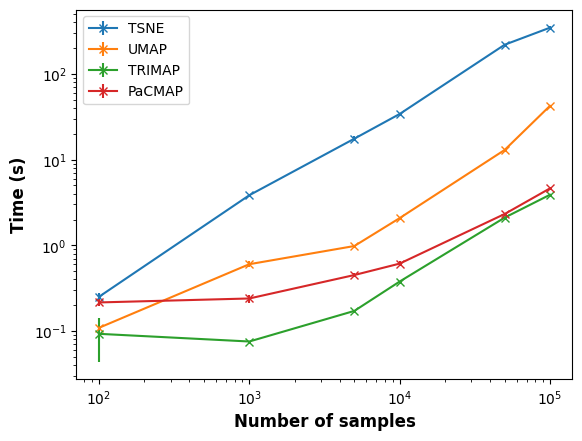

In [11]:
# Plot with errorbars std
fig, ax = plt.subplots()
for method in methods:
    means = np.array([np.mean(times[n][method.__class__.__name__]) for n in N])
    stds = np.array([np.std(times[n][method.__class__.__name__]) for n in N])
    ax.errorbar(N, means, yerr=stds, label=method.__class__.__name__, fmt="x-")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Number of samples", fontsize = 12, fontweight = "bold")
ax.set_ylabel("Time (s)", fontsize = 12, fontweight = "bold")
ax.legend()
plt.show()

# Stability

In [19]:
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import pairwise_distances
from itertools import combinations

def compute_pairwise_spearman(matrix1, matrix2):
    """
    Computes Spearman correlation between two pairwise distance matrices.
    """
    d1 = matrix1[np.triu_indices_from(matrix1, k=1)]
    d2 = matrix2[np.triu_indices_from(matrix2, k=1)]
    corr, _ = spearmanr(d1, d2)
    return corr

def stability_spearman(dr_model, data, sample_size=500, n_runs=10, random_state=None, method_name=""):
    rng = np.random.default_rng(random_state)
    idx = rng.choice(len(data), size=sample_size, replace=False)
    sample = data[idx]

    embeddings = []
    for _ in range(n_runs):
        if method_name == "TriMap":
            np.random.seed(int(rng.integers(1e6)))  # Seed NumPy RNG
            model = dr_model()
        else:
            model = dr_model(random_state=int(rng.integers(1e6)))  # Force int
        embeddings.append(model.fit_transform(sample))


    distance_matrices = [pairwise_distances(embed) for embed in embeddings]
    correlations = [
        compute_pairwise_spearman(dm1, dm2)
        for i, dm1 in enumerate(distance_matrices)
        for j, dm2 in enumerate(distance_matrices) if j > i
    ]
    return np.mean(correlations), np.std(correlations)

# Define DR model wrappers
def tsne_model(random_state=None):
    return TSNE(n_components=2, perplexity=30, init='random', random_state=random_state)

def umap_model(random_state=None):
    return UMAP(n_components=2, random_state=random_state)

def trimap_model(random_state=None):
    return TRIMAP(n_dims=2)

def pacmap_model(random_state=None):
    return PaCMAP(n_components=2, random_state=random_state)


In [32]:
import warnings

warnings.filterwarnings('ignore')

# Compute stability for each method
N = 10000
n_runs = 10

rows = []
for dataset_name in datasets_names:
    X = datasets[dataset_name]
    print(f"Computing stability for {dataset_name} with sample size {N} and {n_runs} runs...")

    results = {
        "TSNE": stability_spearman(tsne_model, X, sample_size=N, n_runs=n_runs),
        "UMAP": stability_spearman(umap_model, X, sample_size=N, n_runs=n_runs),
        "TRIMAP": stability_spearman(trimap_model, X, sample_size=N, n_runs=n_runs),
        "PACMAP": stability_spearman(pacmap_model, X, sample_size=N, n_runs=n_runs),
    }

    for method, (mean_stability, std_dev) in results.items():
        rows.append({
            "Method": method,
            "Mean Stability": mean_stability,
            "Std Dev": std_dev,
            "Dataset": dataset_name
        })

results_df = pd.DataFrame(rows, columns=["Method", "Mean Stability", "Std Dev", "Dataset"])

Computing stability for rts with sample size 10000 and 10 runs...


Computing stability for pdl with sample size 10000 and 10 runs...


Computing stability for ioc with sample size 10000 and 10 runs...


Computing stability for mjf with sample size 10000 and 10 runs...


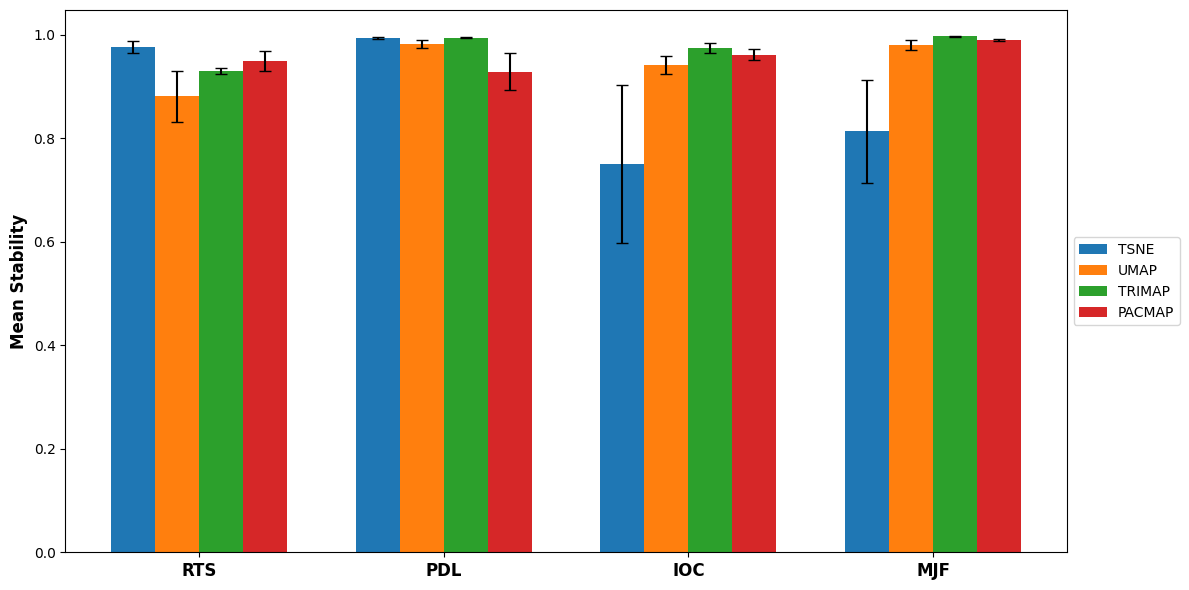

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))

methods = ["TSNE", "UMAP", "TRIMAP", "PACMAP"]
x = np.arange(len(datasets_names))
width = 0.18

for i, method in enumerate(methods):
    means = results_df[results_df["Method"] == method]["Mean Stability"].values
    stds = results_df[results_df["Method"] == method]["Std Dev"].values
    ax.bar(x + i*width - 1.5*width, means, width, yerr=stds, label=method, capsize=4)

ax.set_xticks(x)
ax.set_xticklabels([d.upper() for d in datasets_names], fontsize=12, fontweight="bold")
ax.set_ylabel("Mean Stability", fontsize=12, fontweight="bold")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.subplots_adjust(right=0.8)
plt.tight_layout()
plt.show()